In [35]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [36]:
"""
This cell gets the data ready to get passed into a pipeline
"""
#Import the Data set
df = pd.read_csv("data\\Traffic.csv")

#Get the inputs and target
X = df.drop(columns="Traffic Situation")
y = df["Traffic Situation"]

# Well use this mappng to change the data into numerics
day_mapping = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}

X['Day of the week'] = X['Day of the week'].map(day_mapping)


#TODO Maybe Consider making the data cnyndrical
#This turns time into just minutes as a numeric
X["hour"] = pd.to_datetime(X["Time"], format='%I:%M:%S %p').dt.hour  
X["minute"] = pd.to_datetime(X["Time"], format='%I:%M:%S %p').dt.minute  
X["Time"] = X["hour"] * 60 + X["minute"]
X = X.drop(columns=['hour', 'minute'])

#Change the target to numericas
target_mapping = {
    'heavy': 0,
    'high' : 1,
    'normal' : 2,
    'low' : 3
}

y = y.map(target_mapping)

#Get the training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=42)

In [37]:
# Define features
#TODO, look at catergorical and non catergotical representation of date
numeric_features = ['Date', 'Time', 'CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total']
categorical_features = ['Day of the week']

# Numerical pipeline
numerical_pipeline = Pipeline([
    ("scalar", StandardScaler()) #We're gonna normalize the numeric data 
])

#This is for the catergorical features
categorical_pipeline = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore")) #Shouldn't have to worry about unknowns 
])

#Put it into one preprosser
preprocessor = ColumnTransformer([
    ("num", numerical_pipeline, numeric_features),
    ("cat", categorical_pipeline, categorical_features)
])

In [38]:
#This is a gradeient boosted pipeline
gb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)) #I Can mess around with all of these
])

#Train the model
gb_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = gb_pipeline.predict(X_test)

# Evaluate performance
print(f"Gradient Boosting Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Gradient Boosting Accuracy: 0.9950


In [39]:
#This one tests the XGB model
xgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, eval_metric="logloss", random_state=42))
])
#use_label_encoder=False is useful when there is catergorical vars

# Train the model
xgb_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_pipeline.predict(X_test)

# Evaluate performance
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")

XGBoost Accuracy: 0.9966


In [40]:
#This tests different models
models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC()
}

for name, model in models.items():
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])

    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring="accuracy")
    #CV splits the data into 5 sets, and 5 times trains the data on each fold using the other folds for sccuracy
    print(f"{name}: Mean Accuracy = {scores.mean():.4f}")

Logistic Regression: Mean Accuracy = 0.8790
Random Forest: Mean Accuracy = 0.9697
SVM: Mean Accuracy = 0.8756


In [41]:
param_grid = {
    "classifier__n_estimators": [50, 100, 200],
    "classifier__learning_rate": [0.01, 0.1, 0.2],
    "classifier__max_depth": [3, 5, 7]
}

grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters for XGBoost:", grid_search.best_params_)

y_pred_best = grid_search.best_estimator_.predict(X_test)
print(f"This is the accuracy score: {accuracy_score(y_test, y_pred_best):.4f}")

Best Parameters for XGBoost: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__n_estimators': 50}
This is the accuracy score: 0.9954


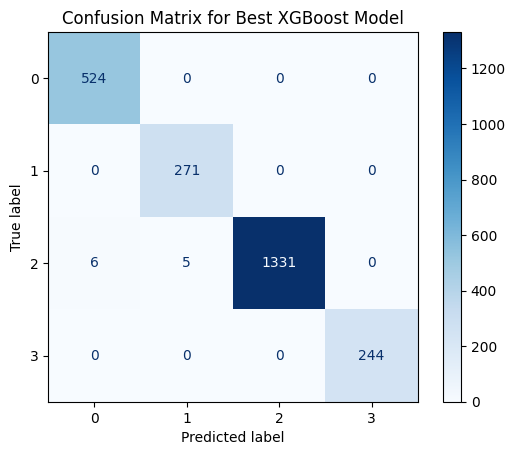

In [42]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_best)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.classes_)
disp.plot(cmap="Blues")  # You can change the colormap if desired
plt.title("Confusion Matrix for Best XGBoost Model")
plt.show()